In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm
import seaborn as sns

import sys 
from path_overlap import * 

# optimize for control betas 

In [2]:
def res_matrix(A, num_layers, betas, S):
    diagS = np.zeros((len(S), len(S)))
    for i in range(len(S)):
        if S[i]==1:
            diagS[i,i] = 1;
    Ss, diagSs = {}, {}
    Ss[0] = S;
    diagSs[0] = diagS
    for i in range(num_layers-1):
        diagSs[i+1] = np.dot(np.dot(diagSs[i], A), diagS) 
        for l in range(len(S)):
            w = np.sum(diagSs[i+1][:,l]) 
            if w!=0:
                diagSs[i+1][:,l] = diagSs[i+1][:,l] / (betas[l] + np.sum(diagSs[i+1][:,l]));
    return diagSs;


def objective_fun(x):
    test_res = compute_single_task_interference(A, task, num_layers, x)
    single_task_prob = test_res[task[0], task[-1]]
    if single_task_prob!=0:
        return -np.log(single_task_prob)
    else:
        return 0;
    
def compute_single_task_interference(A, t, nl, b):
    activated_nodes = np.zeros(A.shape[0],)
    for s in t:
        activated_nodes[s] = 1
    iterated_matrices = res_matrix(A, nl, b, activated_nodes)
    return iterated_matrices[nl-1];

def objective_fun_multitask(x):

    test_res = compute_multitask_interference(A, tasks, num_layers, x)
    compound_prob = 1;
    for task in tasks:
        compound_prob *= test_res[task[0], task[-1]]
    if compound_prob!=0:
        return -np.log(compound_prob)
    else:
        return 0;

def compute_multitask_interference(A, tl, nl, b):
    activated_nodes = np.zeros(A.shape[0],)
    for t in tl:
        for s in t:
            activated_nodes[s] = 1
    iterated_matrices = res_matrix(A, nl, b, activated_nodes)
    return iterated_matrices[nl-1];

def activated_nodes(A, tl):
    activated_nodes = np.zeros(A.shape[0],)
    for t in tl:
        for s in t:
            activated_nodes[s] = 1
    return activated_nodes;

In [3]:
def delta_cost(mp):
    return [(x[0]-x[1])/x[0] for x in mp];

def delta_beta_ratio(x, betas0):
    return np.mean((betas0 - x) / betas0);

In [4]:
def are_structural_interfering(p1, p2):
    if set(p1[1:]).intersection(set(p2[1:])):
        return True;
    else:
        return False;
    
def multitask_subgraph(g, paths):
    nodes = []
    for t in paths:
        nodes.extend(t);
    nodes = list(set(nodes))
    return nx.subgraph(g, nodes);

def are_functionally_interfering(g, paths): #beware it works only for two tasks
    if are_structural_interfering(*paths):
        return False;
    ms = multitask_subgraph(nx.Graph(g), paths)
    if nx.number_connected_components(ms) == len(paths):
        return False;
    else:
        return True;

In [5]:
import numpy as np
from scipy.optimize import minimize, basinhopping

# Only functional interference 


In [6]:
def weighted_task_path_interference(g, p1, p2):
    if len(set(p1[1:]).intersection(set(p2[1:])))>0:
        return True;
    count = 0;
    for l in range(len(p1)-1):
        if p2[l+1] in list(g.successors(p1[l])) or p1[l+1] in list(g.successors(p2[l])):
        	count+=1;
    return count;
def raw_delta_cost(mp, normalized=False):
    if normalized==False:
        return [(x[0]-x[1]) for x in mp];
    else:
        return [(x[0]-x[1])/x[0]  if x[0]>0 else 0 for x in mp];

def raw_delta_beta(x, betas0, func=np.mean, normalized=False):
    if normalized==True:
        return func((betas0 - x) / betas0);
    else:
        return func((betas0 - x));
    
def boostrap_lr(x, y, iterations=500):
    X, Y = np.array(x), np.array(y)
    coeff, inter = [], []
    for i in range(0, iterations):
        sample_index = np.random.choice(range(0, len(y)), len(y))

        X_samples = X[sample_index]
        y_samples = y[sample_index]    

        lr = LinearRegression()
        lr.fit(X_samples, y_samples)
        coeff.append(lr.coef_)
        inter.append(lr.intercept_)
    return coeff, inter;


In [7]:

def single_task_in_multitask_prob(t, sg, betas_t, nus, weight_func=np.exp, attr='capacity', verbose=False):
    prob = 1;
    w  = nx.get_edge_attributes(sg, attr)
    for i, n in enumerate(t[1:]):
        # probability of propagating the right path
        in_n = list(sg.predecessors(n));
        predecessor_probs = []
        Z = weight_func(betas_t[n]) + np.sum([weight_func(w[(x,n)]**nus[n]) for x in in_n])
        prob *= (weight_func(w[(t[i],n)]**nus[n]) / Z);
    return prob;

    
def compute_multitask_interference(gg, tl, nl, b, nu):
    probs = []
    for t in tl:
        probs.append(single_task_in_multitask_prob(t, gg, b, nu, weight_func=np.exp, attr='weight'))
    return probs;

def objective_fun_multitask(x):
    n = int(len(x)/2)
    probs = compute_multitask_interference(sg, new_tasks, num_layers, x[:n], x[n:])
    compound_prob = 1;
    for prob in probs:
        compound_prob *= prob;
    if compound_prob!=0:
        return -np.log(compound_prob)
    else:
        return 0;
    

In [8]:
def subgraph_relabel(gg, ts):
    nn = []
    for t in ts:
        nn.extend(t)
        nn = list(set(nn))
    sg = nx.subgraph(gg,  nn);
    rel_dict = dict(zip(sg.nodes(), list(range(sg.number_of_nodes()))))
    sg = nx.relabel_nodes(sg, rel_dict);
    new_ts = []
    for t in ts:
        new_ts.append([rel_dict[x] for x in t]);
    return sg, new_ts;


In [9]:
def new_strong_weak_graph(num_layers, num_dense, num_sparse, weak_density, strong_mu, strong_std, weak_mu, weak_std, frac=.8):
    tot_units = num_dense + num_sparse;
    G = multipartite_network(num_layers, num_dense, num_sparse, 0.0)
    rel_dict = dict(zip(G.nodes(), range(G.number_of_nodes())))
    inv_rel_dict = dict(zip(range(G.number_of_nodes()), G.nodes()))
    
    G  = nx.relabel_nodes(G, rel_dict)
    strong_w = np.random.normal(strong_mu, strong_std, G.number_of_edges())
    nx.set_edge_attributes(G, dict(zip(G.edges(), strong_w)), 'weight')
    strong_paths = []
    for s in range(tot_units):
        for t in range((num_layers-1)*tot_units, (num_layers)*tot_units):
#             print(s,t, list(nx.all_simple_paths(G,s,t)))
            strong_paths.extend(nx.all_simple_paths(G,s,t))
#     print((strong_paths))
    
    Gr = multipartite_network(num_layers, num_dense+num_sparse, 0,  weak_density)
    Gr = rewire_multipartite_network(Gr, tot_units, 1, rewire_iters=int(frac * Gr.number_of_edges()))
    Gr  = nx.relabel_nodes(Gr, rel_dict)
    weak_mu, weak_std = 1, .2
    weak_w = np.random.normal(weak_mu, weak_std, Gr.number_of_edges())
    weak_w_dict = dict(zip(Gr.edges(), weak_w))
    for edge in Gr.edges():
        if not G.has_edge(edge[0], edge[1]):
            G.add_edge(edge[0], edge[1], weight=weak_w_dict[edge])
    del Gr;
    weak_paths = []
    for s in range(tot_units):
        for t in range((num_layers-1)*tot_units, (num_layers)*tot_units):
            weak_paths.extend(nx.all_simple_paths(G,s,t))
#     print(len(weak_paths))
    for path in strong_paths:
        if path in weak_paths:
            weak_paths.remove(path)
    return G, strong_paths, weak_paths;


In [10]:

beta, nu0,  control_frac = 1.49, 1, 0.1
num_layers_range = range(3,9)
beta_bounds_i = (1, 1.5)
nu_bounds_i  = (0, 2)

sw_layer_multitask_performance, ww_layer_multitask_performance = {}, {}

max_single_tasks = 100;
max_num_loops, max_num_combos = 100, 200

num_dense, num_sparse = 6, 9
tot_units = num_dense + num_sparse
# density = 1

args = weak_density, strong_mu, strong_std, weak_mu, weak_std = .3, 5, 1, 1, .2

for num_layers in tqdm(num_layers_range):
    
    G, strong_paths, weak_paths = new_strong_weak_graph(num_layers, num_dense, num_sparse,*args)# weak_density, strong_mu, strong_std, weak_mu, weak_std)    nx.set_edge_attributes(rel_rew_MPG, dict(zip(rel_rew_MPG.edges(), np.random.rand(rel_rew_MPG.number_of_edges()))), 'weight')

    strong_weak_fun_interference = []
    count = 0
    while len(strong_weak_fun_interference)<max_num_combos and count<max_num_loops:
        count+=1
        el1, el2 = np.random.choice(range(len(strong_paths))), np.random.choice(range(len(weak_paths)))
        double_task = [strong_paths[el1], weak_paths[el2]]
        if are_functionally_interfering(G, double_task): 
                strong_weak_fun_interference.append(double_task)


    sw_layer_multitask_performance[num_layers] = []

    for tasks in tqdm(strong_weak_fun_interference):
        task_res = []
        g = G.copy()
        sg, new_tasks = subgraph_relabel(g, tasks);
        beta_vec = [beta] * sg.number_of_nodes()
        nu_vec = [nu0] * sg.number_of_nodes()
        
        # automatic execution 
        probs = compute_multitask_interference(sg, list(new_tasks), num_layers, beta_vec, nu_vec) #to be fixed but oh well
        compound_prob = 1;
        for prob in probs:
            compound_prob *= prob;
        task_res.append(-np.log(compound_prob))
        
        
        # controlled case
        x = beta_vec.copy()
        bnds = [beta_bounds_i]*len(beta_vec)
        x.extend(nu_vec)
        bnds.extend([nu_bounds_i]*len(nu_vec))
        bnds = tuple(bnds)        
        from scipy.optimize import NonlinearConstraint
        sol = minimize(objective_fun_multitask, x, method = 'SLSQP', bounds = bnds)#, constraints=nlc)#SLSQP
        probs = compute_multitask_interference(sg, list(new_tasks), num_layers, sol.x[:sg.number_of_nodes()],
                                               sol.x[sg.number_of_nodes():])
        compound_prob = 1;
        for prob in probs:
            compound_prob *= prob
        task_res.append(-np.log(compound_prob))
        task_res.append(sol.x)
        task_res.append(weighted_task_path_interference(G, tasks[0], tasks[1]))
        sw_layer_multitask_performance[num_layers].append(task_res)
    
    
    weak_weak_fun_interference = []
    count = 0
    while len(weak_weak_fun_interference)<max_num_combos and count<max_num_loops:
        count+=1
        el1, el2 = np.random.choice(range(len(weak_paths))), np.random.choice(range(len(weak_paths)))
        double_task = [weak_paths[el1], weak_paths[el2]]
        if are_functionally_interfering(G, double_task): 
                weak_weak_fun_interference.append(double_task)


    ww_layer_multitask_performance[num_layers] = []

    for tasks in tqdm(weak_weak_fun_interference):
        task_res = []
        g = G.copy()
        sg, new_tasks = subgraph_relabel(g, tasks);
        beta_vec = [np.exp(beta)] * sg.number_of_nodes()
        nu_vec = [nu0] * sg.number_of_nodes()
        
        # automatic execution 
        probs = compute_multitask_interference(sg, list(new_tasks), num_layers, beta_vec, nu_vec) #to be fixed but oh well
        compound_prob = 1;
        for prob in probs:
            compound_prob *= prob;
        task_res.append(-np.log(compound_prob))
        
        
        # controlled case

        x = beta_vec.copy()
        bnds = [beta_bounds_i]*len(beta_vec)
        x.extend(nu_vec)
        bnds.extend([nu_bounds_i]*len(nu_vec))
        bnds = tuple(bnds)
        from scipy.optimize import NonlinearConstraint
        sol = minimize(objective_fun_multitask, x, method = 'SLSQP', bounds = bnds)#, constraints=nlc)#SLSQP
        probs = compute_multitask_interference(sg, list(new_tasks), num_layers, sol.x[:sg.number_of_nodes()],
                                               sol.x[sg.number_of_nodes():])
        compound_prob = 1;
        for prob in probs:
            compound_prob *= prob
        task_res.append(-np.log(compound_prob))
        task_res.append(sol.x)
        task_res.append(weighted_task_path_interference(G, tasks[0], tasks[1]))
        ww_layer_multitask_performance[num_layers].append(task_res)
    
    
    
        

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
def task_delta_cost(tr, norm=False):
    if norm==False:
        return tr[0]-tr[1];
    else:
        return (tr[0]-tr[1])/tr[0]

ww_delta_costs, ww_delta_costs_norm, sw_delta_costs, sw_delta_costs_norm = {}, {}, {}, {}
for num_layers in num_layers_range:
    ww_delta_costs[num_layers] = [task_delta_cost(x) for x in ww_layer_multitask_performance[num_layers]]
    ww_delta_costs_norm[num_layers] = [task_delta_cost(x, True) for x in ww_layer_multitask_performance[num_layers]]
    sw_delta_costs[num_layers] = [task_delta_cost(x) for x in sw_layer_multitask_performance[num_layers]]
    sw_delta_costs_norm[num_layers] = [task_delta_cost(x, True) for x in sw_layer_multitask_performance[num_layers]]


In [13]:
def task_delta_cost(tr, norm=False):
    if norm==False:
        return tr[0]-tr[1];
    else:
        return (tr[0]-tr[1])/tr[0]

sw_automatic_cost, ww_automatic_cost = {}, {}
sw_controlled_cost, ww_controlled_cost = {}, {}
for num_layers in num_layers_range:
    sw_automatic_cost[num_layers] = [x[0] for x in sw_layer_multitask_performance[num_layers]]
    ww_automatic_cost[num_layers] = [x[0] for x in ww_layer_multitask_performance[num_layers]]
    sw_controlled_cost[num_layers] = [x[1] for x in sw_layer_multitask_performance[num_layers]]
    ww_controlled_cost[num_layers] = [x[1] for x in ww_layer_multitask_performance[num_layers]]


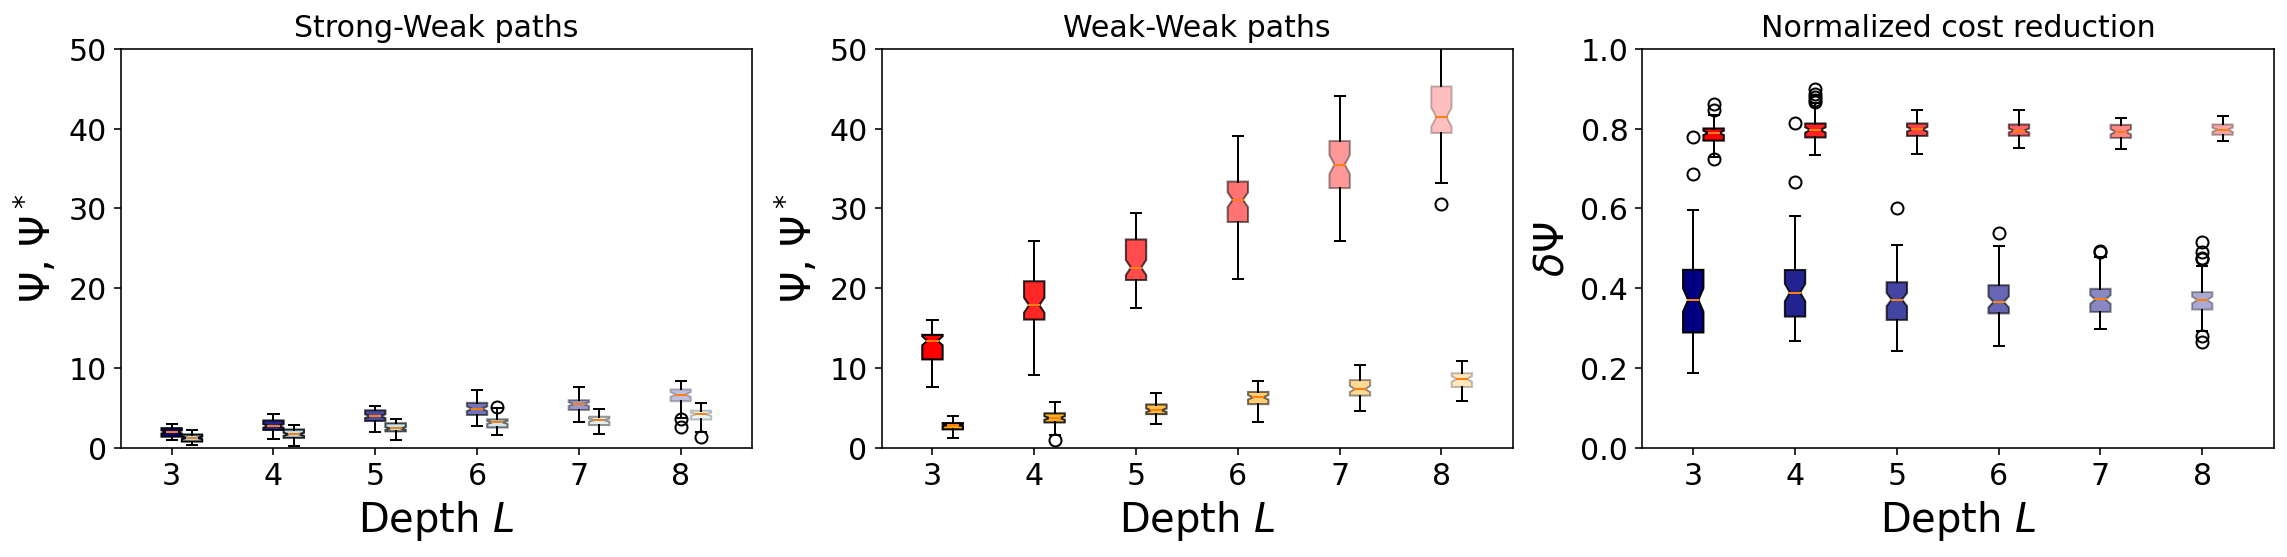

In [15]:
fig = plt.figure(figsize=(16, 4))
ax = plt.subplot(131)
width = .2

sw_double_boxes = {}

sw_double_boxes['automatic'] = ax.boxplot(sw_automatic_cost.values(),
                                       positions=np.array(num_layers_range), widths=width,
                                       notch=True,
                                       vert=True,  # vertical box alignment
                                       patch_artist=True)

sw_double_boxes['controlled'] = ax.boxplot(sw_controlled_cost.values(),
                                       positions=np.array(num_layers_range)+width, widths=width,
                                       notch=True,
                                       vert=True,  # vertical box alignment
                                       patch_artist=True)
plt.xticks(num_layers_range, num_layers_range, fontsize=15);
plt.xlabel(r'Depth $L$', fontsize=20)
plt.ylabel(r'$\Psi$, $\Psi^*$', fontsize=20)
plt.yticks(fontsize=15)
colors = ['navy', 'lightblue', 'orange']
for i, name in enumerate(sw_double_boxes.keys()):
    for j, patch in enumerate(sw_double_boxes[name]['boxes']):
        patch.set_facecolor(colors[i])
        if i<2:
            patch.set_alpha(1 - 0.9*j/len(num_layers_range))
        else:
            patch.set_alpha(.8)
plt.title('Strong-Weak paths', fontsize=15)
plt.ylim(0,50)

ax = plt.subplot(132)
ww_double_boxes = {}
ww_double_boxes['automatic'] = ax.boxplot(ww_automatic_cost.values(),
                                       positions=np.array(num_layers_range), widths=width,
                                       notch=True,
                                       vert=True,  # vertical box alignment
                                       patch_artist=True)

ww_double_boxes['controlled'] = ax.boxplot(ww_controlled_cost.values(),
                                       positions=np.array(num_layers_range)+width, widths=width,
                                       notch=True,
                                       vert=True,  # vertical box alignment
                                       patch_artist=True)
plt.xticks(num_layers_range, num_layers_range, fontsize=15);
plt.xlabel(r'Depth $L$', fontsize=20)
plt.ylabel(r'$\Psi$, $\Psi^*$', fontsize=20)
plt.yticks(fontsize=15)
colors = ['red', 'orange']
for i, name in enumerate(ww_double_boxes.keys()):
    for j, patch in enumerate(ww_double_boxes[name]['boxes']):
        patch.set_facecolor(colors[i])
        if i<2:
            patch.set_alpha(1 - 0.9*j/len(num_layers_range))
        else:
            patch.set_alpha(.8)

plt.title('Weak-Weak paths', fontsize=15)
plt.ylim(0,50)

ax = plt.subplot(133)
norm_double_boxes = {}
norm_double_boxes['sw'] = ax.boxplot(sw_delta_costs_norm.values(),
                                       positions=np.array(num_layers_range), widths=width,
                                       notch=True,
                                       vert=True,  # vertical box alignment
                                       patch_artist=True)


plt.xticks(num_layers_range, num_layers_range, fontsize=15);
plt.xlabel(r'Depth $L$', fontsize=20)


# ax = plt.subplot(122)
norm_double_boxes['ww'] = ax.boxplot(ww_delta_costs_norm.values(),
                                       positions=np.array(num_layers_range)+width, widths=width,
                                       notch=True,
                                       vert=True,  # vertical box alignment
                                       patch_artist=True)
plt.xticks(num_layers_range, num_layers_range, fontsize=15);
plt.ylabel(r'$\delta \Psi$', fontsize=20)

colors = ['navy', 'red', 'orange']
for i, name in enumerate(norm_double_boxes.keys()):
    for j, patch in enumerate(norm_double_boxes[name]['boxes']):
        patch.set_facecolor(colors[i])
        if i<2:
            patch.set_alpha(1 - 0.8*j/len(num_layers_range))
        else:
            patch.set_alpha(.8)
#     plt.text(3, 0.1+0.1*i, name, fontsize=20, color=colors[i])

plt.ylim(0,1)
plt.yticks(fontsize=15)

plt.title('Normalized cost reduction', fontsize=15)
plt.tight_layout()

In [16]:
from scipy.stats import ks_2samp, ttest_ind, kruskal, levene

for num_layers in num_layers_range:
    print(num_layers, ttest_ind(ww_delta_costs_norm[num_layers], sw_delta_costs_norm[num_layers], 
                                equal_var=False, alternative='greater'))
print('\n')

for num_layers in num_layers_range:
    print(num_layers, levene(ww_delta_costs_norm[num_layers], sw_delta_costs_norm[num_layers]))

3 Ttest_indResult(statistic=28.382805123980937, pvalue=6.1441415911773786e-43)
4 Ttest_indResult(statistic=33.10698545063517, pvalue=1.2569528125509242e-51)
5 Ttest_indResult(statistic=55.65018368392389, pvalue=5.547590435534767e-79)
6 Ttest_indResult(statistic=59.60532050668866, pvalue=1.5345991695615563e-68)
7 Ttest_indResult(statistic=70.03612403960253, pvalue=2.3976582591479634e-88)
8 Ttest_indResult(statistic=70.98499607860236, pvalue=2.0278316540003264e-76)


3 LeveneResult(statistic=62.038756795878506, pvalue=7.703751699766395e-13)
4 LeveneResult(statistic=27.14496980307869, pvalue=7.140844813911039e-07)
5 LeveneResult(statistic=37.18720573744452, pvalue=8.912238356514972e-09)
6 LeveneResult(statistic=39.0075453378941, pvalue=5.0437074878855815e-09)
7 LeveneResult(statistic=19.97607097853995, pvalue=1.679490454143604e-05)
8 LeveneResult(statistic=19.090770782758973, pvalue=2.605500459764064e-05)


# Control policies

In [17]:
quant = 'nu'

if quant == 'beta':
    m, M = 0, np.diff(beta_bounds_i)[0]
if quant=='nu':
    m, M = nu_bounds_i
    

sw_control_policies = {}
ww_control_policies = {}
for num_layers in num_layers_range:
    sw_control_policies[num_layers] = []
    ww_control_policies[num_layers] = []
    for x in sw_layer_multitask_performance[num_layers]:
        N = int(len(x[-2])/2)
        if quant=='beta':
            sw_control_policies[num_layers].extend(beta-x[-2][:N]);
        elif quant=='nu':
            sw_control_policies[num_layers].extend(x[-2][N:]);
    for x in ww_layer_multitask_performance[num_layers]:
        if quant=='beta':
            ww_control_policies[num_layers].extend(beta - x[-2][:N]);
        elif quant=='nu':
            ww_control_policies[num_layers].extend(x[-2][N:]);

In [18]:
def clean_numerical_errors(l, m, M):
    return [x for x in l if x>=m and x<=M]

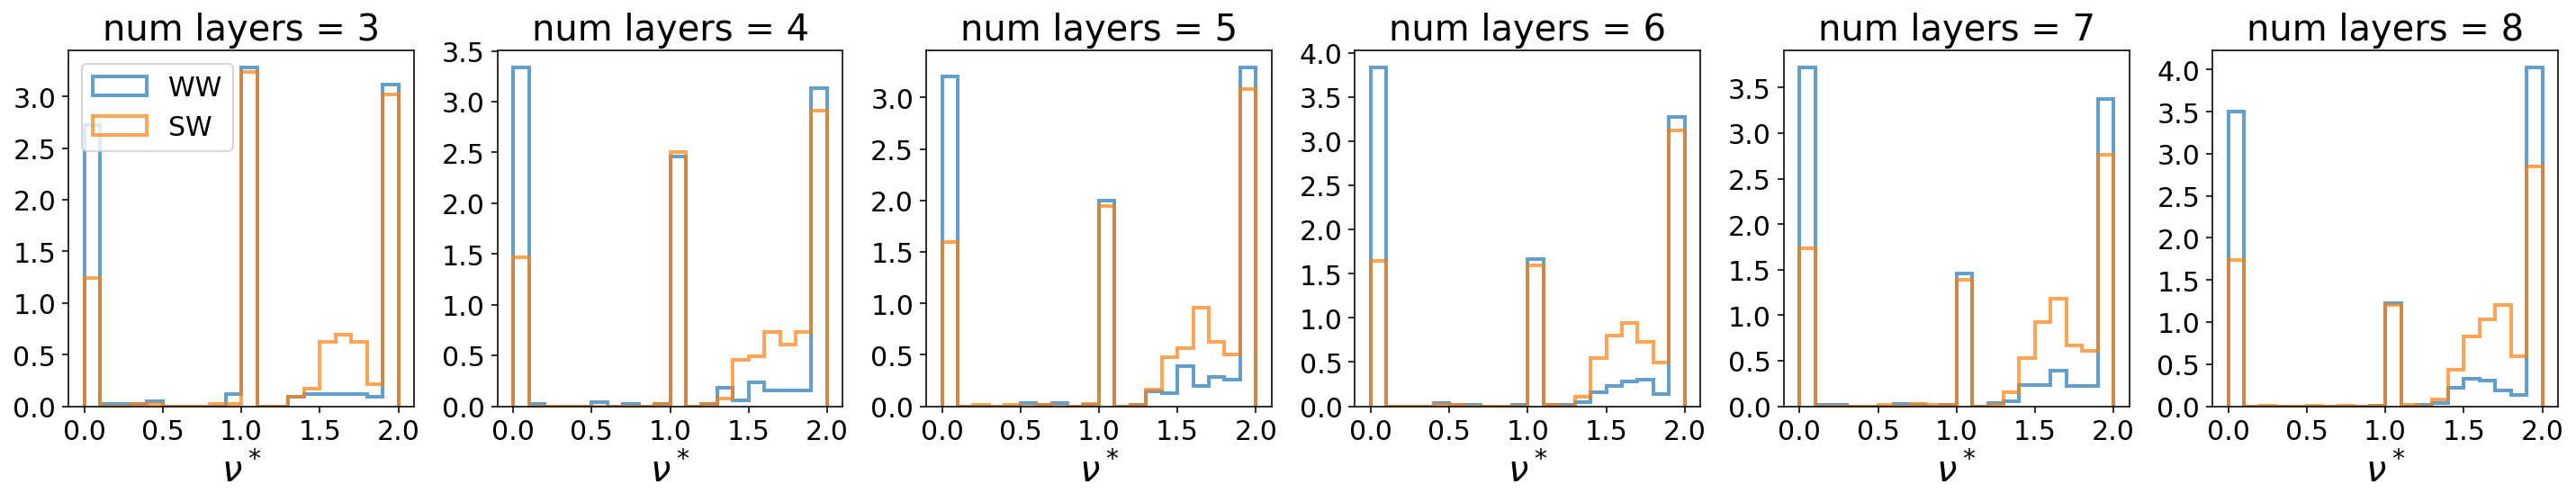

In [21]:
import seaborn as sns
lw = 2
alpha_opac = .7
fig = plt.figure(figsize=(20,4))

for i, k in enumerate(sw_control_policies.keys()):
    plt.subplot(1, 6, i+1)
    plt.hist(clean_numerical_errors(ww_control_policies[k], m, M), bins=20, density=True, label='WW',
             alpha=alpha_opac, linewidth=lw, histtype='step')
    plt.hist(clean_numerical_errors(sw_control_policies[k], m, M), bins=20, density=True, label='SW', histtype='step', 
             alpha=alpha_opac, linewidth=lw)
    plt.title('num layers = '+str(k), fontsize=20)
    if i==0:
        plt.legend(fontsize=15, loc=2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if quant=='beta':
        plt.xlabel(r'$\Delta\beta^*$', fontsize=20)
    if quant=='nu':
        plt.xlabel(r'$\nu^*$', fontsize=20)

plt.tight_layout()